In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from game_environments.breakthrough.breakthrough import BTBoard, config as BTconfig
import random
from tqdm import tqdm
from PIL import Image
import ast
from itertools import permutations
from monte_carlo.mcts import MCTS
from monte_carlo.mctsnode import Node
import torch
import torch.optim as optim
import numpy as np
from game_environments.breakthrough.breakthrough import BTBoard,config
from neural_networks.breakthrough.breakthrough_nn import BreakthroughNN
import matplotlib as mpl
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDClassifier
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDClassifier
from sklearn.metrics import roc_auc_score
import copy
import matplotlib.patches as mpatches
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
import operator
from collections import namedtuple

mpl.style.use('seaborn')

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)


def from_np_array(array_string):
    array_string = ','.join(array_string.replace('[ ', '[').split())
    return np.array(ast.literal_eval(array_string))


GAME = {
    "breakthrough": BTBoard(np.zeros([6,6]), 1),
}
selected_game = GAME["breakthrough"]
initial_state = selected_game.initial_state()

primary_nn = BreakthroughNN(initial_state.rows, initial_state.cols, initial_state.get_move_amount())
primary_nn.loadmodel('./trained_models', 'session2_res3_gen_300.tar')

GAME = {
    "breakthrough": BTBoard(np.zeros([6,6]), 1),
}

selected_game = GAME["breakthrough"]
initial_state = Node(selected_game.initial_state(),"START")

seen_states = {}

frontier = [initial_state]

generate_new_data = False
new_data_size = 20000
dfs = False
monte_tree = MCTS()

NEURAL_NETWORK_THINK = 20

if generate_new_data:
    df = pd.DataFrame(columns=["id",
                               "player",
                               "state",
                               "terminal", 
                               "player_piece_amount", 
                               "piece_difference", 
                               "furthest_piece", 
                               "furthest_piece_difference",
                               "average_distance",
                               "lorentz_horey",
                               "lorentz_horey_difference"], 
                      dtype=np.int64
                      )
    state_id = 0
    
    while state_id < new_data_size:
        print("pre-game:",state_id ,"left:",new_data_size-state_id)
        curr_node = initial_state
        while not curr_node.gamestate.is_terminal():
            pi = monte_tree.get_policy(curr_node,NEURAL_NETWORK_THINK, primary_nn, 1)
            for i,child in enumerate(curr_node.children):
                if not child:
                    pi[i] = 0
            pi = pi / sum(pi)

            working_state = curr_node.gamestate

            if not working_state.__hash__() in seen_states:
                heuristics = working_state.get_heuristics()
                df = df.append({
                    'id':state_id,
                    'state':working_state.encode_state(),
                    'player':working_state.player,
                    'terminal':working_state.is_terminal(),
                    'player_piece_amount':heuristics[0][1],
                    'piece_difference':heuristics[1][1],
                    'furthest_piece':heuristics[2][1],
                    'furthest_piece_difference':heuristics[3][1],
                    'average_distance':heuristics[4][1],
                    'lorentz_horey':heuristics[5][1],
                    'lorentz_horey_difference':heuristics[6][1]
                },ignore_index=True)
                seen_states[working_state.__hash__()] = True
                state_id += 1

            curr_node = np.random.choice(curr_node.children, p=pi)
        working_state = curr_node.gamestate
        if not working_state.__hash__() in seen_states:
            heuristics = working_state.get_heuristics()
            df = df.append({
                'id':state_id,
                'state':working_state.encode_state(),
                'player':working_state.player,
                'terminal':working_state.is_terminal(),
                'player_piece_amount':heuristics[0][1],
                'piece_difference':heuristics[1][1],
                'furthest_piece':heuristics[2][1],
                'furthest_piece_difference':heuristics[3][1],
                'average_distance':heuristics[4][1],
                'lorentz_horey':heuristics[5][1],
                'lorentz_horey_difference':heuristics[6][1]
            },ignore_index=True)
            seen_states[working_state.__hash__()] = True
            state_id += 1
        
    df.set_index('id') 

    df.to_csv(f'./mcts_moves_heuristic_{new_data_size}_think_{NEURAL_NETWORK_THINK}.csv')
else:
    df = pd.read_csv(f'./mcts_moves_heuristic_{new_data_size}_think_{NEURAL_NETWORK_THINK}.csv', converters={'state': from_np_array}).set_index('id')

df.average_distance = df.average_distance.abs()

In [92]:
class StateDataset(Dataset):
    def __init__(self, _x, _y):
        self.X = _x.copy()
        self.y = _y.copy()
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X.iloc[idx], self.y.iloc[idx]

testing_helper_tuple = namedtuple("testing_helper_tuple", "COLUMN_NAME POSOP NEGOP VALUE SAMPLE_SIZE")

testing_helper = {
    "piece_difference": testing_helper_tuple("piece_difference", operator.ge, operator.lt, 2, 1000),
    "furthest_piece_difference": testing_helper_tuple("furthest_piece_difference", operator.ge, operator.lt, 1, 2500),
    "average_distance": testing_helper_tuple("average_distance", operator.lt, operator.ge, 0.25, 2500),
    "lorentz_horey_difference": testing_helper_tuple("lorentz_horey_difference", operator.ge, operator.lt, 3, 2500)
}

test_tuple = namedtuple("test_tuple", "DATALOADER OP VALUE")

test_container = {}

for key, testtuple in testing_helper.items():
    positive = df[ testtuple.POSOP(df[testtuple.COLUMN_NAME], testtuple.VALUE)].sample(testtuple.SAMPLE_SIZE)
    random = df[testtuple.NEGOP(df[testtuple.COLUMN_NAME], testtuple.VALUE )].sample(testtuple.SAMPLE_SIZE)
    tcav_df = pd.concat([positive, random])
    tcav_X = tcav_df['state']
    tcav_y = tcav_df['piece_difference']
    tcav_DS = StateDataset(tcav_X,tcav_y)
    tcav_DL = DataLoader(tcav_DS, shuffle=True, batch_size=1)
    test_container[testtuple.COLUMN_NAME] = test_tuple(tcav_DL, testtuple.POSOP, testtuple.VALUE)
"""
all_piece_diff_X = df['state']
all_piece_diff_y = df['piece_difference']
all_piece_diff_DS = StateDataset(all_piece_diff_X, all_piece_diff_y)
all_piece_diff_DL = DataLoader(all_piece_diff_DS, shuffle=True, batch_size=1)

aggro_positive = df[df['furthest_piece_difference'] >= 1].sample(2500)
aggro_random = df[df['furthest_piece_difference'] < 1].sample(2500)
aggro_diff_tcav_df = pd.concat([aggro_positive, aggro_random])
aggro_diff_X = aggro_diff_tcav_df['state']
aggro_diff_y = aggro_diff_tcav_df['furthest_piece_difference']
aggro_diff_DS = StateDataset(aggro_diff_X, aggro_diff_y)
aggro_diff_DL = DataLoader(aggro_diff_DS, shuffle=True, batch_size=1)

all_aggro_diff_X = df['state']
all_aggro_diff_y = df['furthest_piece_difference']
all_aggro_diff_DS = StateDataset(all_aggro_diff_X,all_aggro_diff_y)
all_aggro_diff_DL = DataLoader(all_aggro_diff_DS, shuffle=True, batch_size=1)

avg_dist_positive = df[df['average_distance'] < 0.25].sample(2500)
avg_dist_random = df[df['average_distance'] >= 0.25].sample(2500)
avg_dist_tcav_df = pd.concat([avg_dist_positive, avg_dist_random])
avg_dist_X = avg_dist_tcav_df['state']
avg_dist_y = avg_dist_tcav_df['average_distance']
avg_dist_DS = StateDataset(avg_dist_X,avg_dist_y)
avg_dist_DL = DataLoader(avg_dist_DS, shuffle=True, batch_size=1)

all_avg_dist_X = df['state']
all_avg_dist_y = df['average_distance']
all_avg_dist_DS = StateDataset(all_avg_dist_X,all_avg_dist_y)
all_avg_dist_DL = DataLoader(all_avg_dist_DS, shuffle=True, batch_size=1)

lorentz_diff_positive = df[df['lorentz_horey_difference'] >= 5].sample(2500)
lorentz_diff_negative = df[df['lorentz_horey_difference'] < 5].sample(2500)
lorentz_diff_tcav_df = pd.concat([lorentz_diff_positive, lorentz_diff_negative])
lorentz_diff_X = lorentz_diff_tcav_df['state']
lorentz_diff_y = lorentz_diff_tcav_df['lorentz_horey_difference']
lorentz_diff_DS = StateDataset(lorentz_diff_X,lorentz_diff_y)
lorentz_diff_DL = DataLoader(lorentz_diff_DS, shuffle=True, batch_size=1)
"""

print(test_container)


{'piece_difference': test_tuple(DATALOADER=<torch.utils.data.dataloader.DataLoader object at 0x7f634527ab20>, OP=<built-in function ge>, VALUE=2), 'furthest_piece_difference': test_tuple(DATALOADER=<torch.utils.data.dataloader.DataLoader object at 0x7f6345568160>, OP=<built-in function ge>, VALUE=1), 'average_distance': test_tuple(DATALOADER=<torch.utils.data.dataloader.DataLoader object at 0x7f634527a700>, OP=<built-in function lt>, VALUE=0.25), 'lorentz_horey_difference': test_tuple(DATALOADER=<torch.utils.data.dataloader.DataLoader object at 0x7f634527a8e0>, OP=<built-in function ge>, VALUE=3)}


In [93]:
percentage = []
roc_auc_scores = []
heuristic_percentage = []
gens = [10*k for k in range(0,31)]

TESTING_CONCEPT = "lorentz_horey_difference"
CURRENT_TEST = test_container[TESTING_CONCEPT]

for g in gens:
    print("doing gen ",g)
    
    game_example = BTBoard(np.zeros([6,6]),1)

    new_df = pd.DataFrame(columns=["id",
                               "player",
                               "state",
                               "terminal", 
                               "player_piece_amount", 
                               "piece_difference", 
                               "furthest_piece", 
                               "furthest_piece_difference",
                               "average_distance",
                               "lorentz_horey",
                               "lorentz_horey_difference"], 
                      dtype=np.int64
                      )


    monte_tree = MCTS()

    primary_nn = BreakthroughNN(game_example.rows, game_example.cols, game_example.get_move_amount())
    primary_nn.loadmodel('./trained_models', f'session2_res5_gen{g}.tar')
    
    
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    
    # HERE WE TRAIN A CAV

    concept_list = []
    activations_list = []
    target_list = []

    outputs = []

    for batch_idx, (data, target) in enumerate(CURRENT_TEST.DATALOADER):
        data.to(device), target.to(device)

        activations = primary_nn.forward_0(data.float())
        activations_list.append(activations.clone().detach().cpu())
        concept_list.append(CURRENT_TEST.OP(target.item(), CURRENT_TEST.VALUE))
        outputs.append(primary_nn.forward_1(activations))
        
    
    lm = SGDClassifier(max_iter=10000)
    tcav_x = [act.flatten().numpy() for act in activations_list]
    tcav_y = concept_list
    tcav_x_train, tcav_x_test, tcav_y_train, tcav_y_test = train_test_split(tcav_x, tcav_y, test_size=0.33)
    lm.fit(tcav_x_train, tcav_y_train)
    y_pred = lm.predict(tcav_x_test)
    roc_auc = roc_auc_score(tcav_y_test, y_pred)
    CAV = lm.coef_
    print("ROC AUC score:", roc_auc)
    roc_auc_scores.append(roc_auc)
    
    flat_cav = CAV.flatten()
    # DONE CREATING THE CAV
    
    # HERE WE SIMULATE A GAME
    seen_states = set()
    state_id = 0
    
    game_lengths = []
    
#     has_heuristic = 0
    
    for i in range(100):
        curr_node = Node(game_example.initial_state(), "START")
        white_playing=True
        game_length = 0
        while not curr_node.gamestate.is_terminal():
            game_length += 1
#             pi = monte_tree.get_policy(curr_node,NEURAL_NETWORK_THINK, primary_nn, temp)

            pi,v = primary_nn.safe_predict(curr_node.gamestate)
            pi = pi.detach().cpu().numpy()[0]
            if not curr_node.is_expanded():
                curr_node.expand()
            for i,child in enumerate(curr_node.children):
                if not child:
                    pi[i] = 0
            pi = pi / sum(pi)
#             if white_playing:
            heuristics = curr_node.gamestate.get_heuristics()
#             has_heuristic += 1 if heuristics[6][1] >= 5 else 0
            new_df = new_df.append({
                'id':state_id,
                'state':curr_node.gamestate.encode_state(),
                'player':curr_node.gamestate.player,
                'terminal':curr_node.gamestate.is_terminal(),
                'player_piece_amount':heuristics[0][1],
                'piece_difference':heuristics[1][1],
                'furthest_piece':heuristics[2][1],
                'furthest_piece_difference':heuristics[3][1],
                'average_distance':heuristics[4][1],
                'lorentz_horey':heuristics[5][1],
                'lorentz_horey_difference':heuristics[6][1],
            },ignore_index=True)
            state_id += 1
            curr_node = np.random.choice(curr_node.children, p=pi)
            white_playing = not white_playing
#         if white_playing:
        new_df = new_df.append({
            'id':state_id,
            'state':curr_node.gamestate.encode_state(),
            'player':curr_node.gamestate.player,
            'terminal':curr_node.gamestate.is_terminal(),
            'player_piece_amount':heuristics[0][1],
            'piece_difference':heuristics[1][1],
            'furthest_piece':heuristics[2][1],
            'furthest_piece_difference':heuristics[3][1],
            'average_distance':heuristics[4][1],
            'lorentz_horey':heuristics[5][1],
            'lorentz_horey_difference':heuristics[6][1],
        },ignore_index=True)
        state_id += 1
        game_lengths.append(game_length)
    new_df.set_index('id') 
    
    # DONE SIMULATING GAME
    
    # HERE WE EVALUATE THE TCAV SCORES
    
    new_df['tcav_score'] = 0
    count_has_hlc = 0
    for idx, row in new_df.iterrows():
        data = torch.FloatTensor(row.state)
        data.to(device)
        activations = primary_nn.forward_0(data.float())

        acts_var = torch.autograd.Variable(activations.clone().detach().to(device), requires_grad=True)
        outputs = primary_nn.forward_1(acts_var)

        # get output we want the gradient wrt (move it picked or the score it gave)
        midx = torch.argmax(outputs[0]).item()
    #     print(outputs[0])
    #     print(outputs[0][0][midx])
    #     for idx,k in enumerate(outputs[0]):
    #         print(idx,k)
    #     print(midx)
    #     break

        # grad wrt value
    #     grad = -torch.autograd.grad(outputs[1], acts_var)[0]

        # grad wrt highest action in policy vector
        grad = -torch.autograd.grad(outputs[0][0][midx], acts_var)[0]

        tcav_score = np.dot(grad.detach().cpu().numpy().flatten(), flat_cav)
        if tcav_score < 0:
            count_has_hlc += 1
        new_df.loc[idx,"tcav_score"] = tcav_score
    percentage.append(count_has_hlc/len(new_df))
#     heuristic_percentage.append(has_heuristic/len(new_df))
    print("perc:",count_has_hlc/len(new_df))
    
avg_dist_percentage = copy.copy(percentage)
roc_auc_curve = copy.copy(roc_auc_scores)
# has_heur_percentage = copy.copy(heuristic_percentage)

doing gen  0
ROC AUC score: 0.60995085995086
perc: 0.141703130259172
doing gen  10
ROC AUC score: 0.6390980152011815
perc: 0.5670949321912919
doing gen  20
ROC AUC score: 0.5935384615384616
perc: 0.43414275202354674
doing gen  30
ROC AUC score: 0.5591174661746617
perc: 0.5566376217324449
doing gen  40
ROC AUC score: 0.5457774269928967
perc: 0.45869947275922673
doing gen  50
ROC AUC score: 0.5466707516339869
perc: 0.4699372925119882
doing gen  60
ROC AUC score: 0.5700920245398773
perc: 0.5286065286065286
doing gen  70
ROC AUC score: 0.5659037095501184
perc: 0.44546794399410466
doing gen  80
ROC AUC score: 0.5709933593482577
perc: 0.5635410240592227
doing gen  90
ROC AUC score: 0.5359984842743463
perc: 0.5199622760138322
doing gen  100
ROC AUC score: 0.6184615384615385
perc: 0.4912478825522304
doing gen  110
ROC AUC score: 0.5814992255322214


KeyboardInterrupt: 

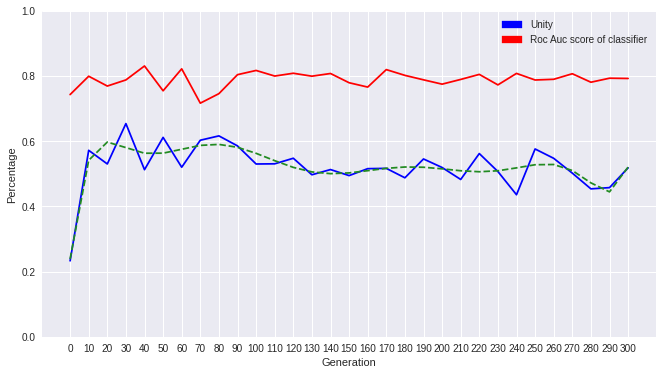

In [28]:
fig = plt.figure(figsize=(11,6))
ticks = np.arange(min(gens), max(gens)+1, 10)
plt.xticks(ticks)
plt.xlabel("Generation")
plt.ylabel("Percentage")
plt.ylim((0,1))

plt.plot(ticks,roc_auc_curve,'r')

# plt.plot(ticks,piece_diff_percentage, "b")
# plt.plot(ticks,aggro_diff_percentage, "b")
plt.plot(ticks,avg_dist_percentage, "b")
# plt.plot(ticks,lorentz_diff_percentage, "b")

# plt.plot(ticks,has_heur_percentage,"y")

# trendline1 = np.polyfit(ticks, piece_diff_percentage, 3)
# p1 = np.poly1d(trendline1)
# trendline2 = np.polyfit(ticks, aggro_diff_percentage, 3)
# p2 = np.poly1d(trendline2)
trendline3 = np.polyfit(ticks, avg_dist_percentage, 9)
p3 = np.poly1d(trendline3)
# trendline4 = np.polyfit(ticks, lorentz_diff_percentage, 3)
# p4 = np.poly1d(trendline4)
# plt.plot(ticks,p1(ticks), '--', color="forestgreen")
# plt.plot(ticks,p2(ticks),"--", color="forestgreen")
plt.plot(ticks,p3(ticks),"--", color="forestgreen")
# plt.plot(ticks,p4(ticks),"--", color="forestgreen")
patches = []
# patches.append(mpatches.Patch(color='b', label='Numbers advantage'))
# patches.append(mpatches.Patch(color='b', label='Aggressiveness'))
patches.append(mpatches.Patch(color='b', label='Unity'))
# patches.append(mpatches.Patch(color='b', label='Lorentz Horey'))
patches.append(mpatches.Patch(color='r', label='Roc Auc score of classifier'))
plt.legend(handles=patches)
plt.show()

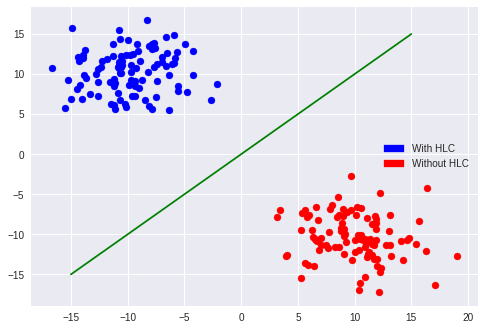

In [64]:
from random import random
import random

lpoints = [((10+((np.random.normal()*3))),-10+((np.random.normal()*3))) for _ in range(100)]
rpoints = [((-10+((np.random.normal()*3))),10+((np.random.normal()*3))) for _ in range(100)]

lx = [i[0] for i in lpoints]
ly = [i[1] for i in lpoints]
rx = [i[0] for i in rpoints]
ry = [i[1] for i in rpoints]
npatches = []
npatches.append(mpatches.Patch(color='b', label='With HLC'))
npatches.append(mpatches.Patch(color='r', label='Without HLC'))

plt.scatter(lx,ly,c="r")
plt.scatter(rx,ry,c="b")
plt.plot([-15,15],[-15,15],c='g')
# plt.arrow(0,0,-1,1,width=0.5,color="g")
plt.legend(handles=npatches)


(array([  31.,  168.,  684., 2314., 5230., 7662., 2927.,  810.,  159.,
          28.]),
 array([-64. , -51.8, -39.6, -27.4, -15.2,  -3. ,   9.2,  21.4,  33.6,
         45.8,  58. ]),
 <BarContainer object of 10 artists>)

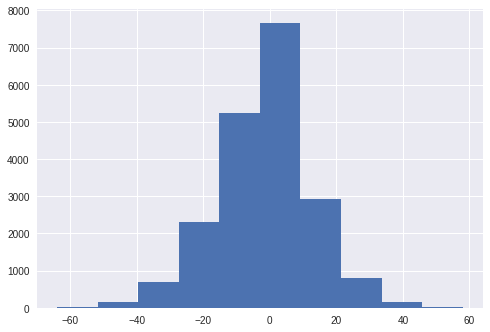

In [3]:
df.lorentz_horey_difference.describe()
plt.hist(df.lorentz_horey_difference)

In [98]:
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDClassifier
from sklearn.metrics import roc_auc_score
import copy

percentage = []


game_example = BTBoard(np.zeros([6,6]),1)

new_df = pd.DataFrame(columns=["id",
                           "player",
                           "state",
                           "terminal", 
                           "player_piece_amount", 
                           "piece_difference", 
                           "furthest_piece", 
                           "furthest_piece_difference",
                           "average_distance",
                           "lorentz_horey",
                           "lorentz_horey_difference"], 
                  dtype=np.int64
                  )


monte_tree = MCTS()

primary_nn = BreakthroughNN(game_example.rows, game_example.cols, game_example.get_move_amount())
primary_nn.loadmodel('./trained_models', f'session2_res5_gen300.tar')

print(len(primary_nn.parameters()))
break


device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# HERE WE SIMULATE A GAME
seen_states = set()
state_id = 0

game_lengths = []

for i in range(1000):
    curr_node = Node(game_example.initial_state(), "START")
    white_playing=True
    game_length = 0
    while not curr_node.gamestate.is_terminal():
        game_length += 1
        pi,v = primary_nn.safe_predict(curr_node.gamestate)
        pi = pi.detach().cpu().numpy()[0]
        if not curr_node.is_expanded():
            curr_node.expand()
        for i,child in enumerate(curr_node.children):
            if not child:
                pi[i] = 0
        pi = pi / sum(pi)
        heuristics = curr_node.gamestate.get_heuristics()
        new_df = new_df.append({
            'id':state_id,
            'state':curr_node.gamestate.encode_state(),
            'player':curr_node.gamestate.player,
            'terminal':curr_node.gamestate.is_terminal(),
            'player_piece_amount':heuristics[0][1],
            'piece_difference':heuristics[1][1],
            'furthest_piece':heuristics[2][1],
            'furthest_piece_difference':heuristics[3][1],
            'average_distance':heuristics[4][1],
            'lorentz_horey':heuristics[5][1],
            'lorentz_horey_difference':heuristics[6][1],
        },ignore_index=True)
        state_id += 1
        curr_node = np.random.choice(curr_node.children, p=pi)
        white_playing = not white_playing
    if white_playing:
        new_df = new_df.append({
            'id':state_id,
            'state':curr_node.gamestate.encode_state(),
            'player':curr_node.gamestate.player,
            'terminal':curr_node.gamestate.is_terminal(),
            'player_piece_amount':heuristics[0][1],
            'piece_difference':heuristics[1][1],
            'furthest_piece':heuristics[2][1],
            'furthest_piece_difference':heuristics[3][1],
            'average_distance':heuristics[4][1],
            'lorentz_horey':heuristics[5][1],
            'lorentz_horey_difference':heuristics[6][1],
        },ignore_index=True)
        state_id += 1
    game_lengths.append(game_length)
new_df.set_index('id') 

print(game_lengths)

AttributeError: 'BreakthroughNN' object has no attribute 'parameters'

(array([  9.,  68., 109., 114., 138., 144., 144., 158.,  81.,  35.]),
 array([12., 17., 22., 27., 32., 37., 42., 47., 52., 57., 62.]),
 <BarContainer object of 10 artists>)

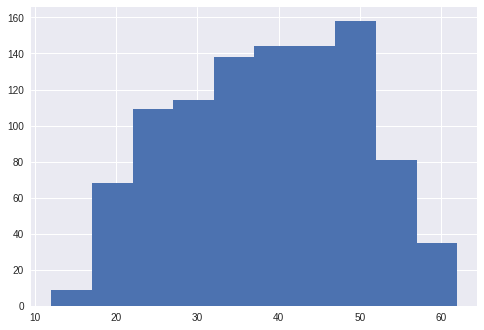

In [14]:
gl = np.array(game_lengths)
gl.mean()+gl.std()
plt.hist(gl)

In [26]:
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDClassifier
from sklearn.metrics import roc_auc_score
import copy

percentage = []
roc_auc_scores = []
gens = [10*k for k in range(0,31)]

for g in gens:
    print("doing gen ",g)
    
    game_example = BTBoard(np.zeros([6,6]),1)



    monte_tree = MCTS()

    primary_nn = BreakthroughNN(game_example.rows, game_example.cols, game_example.get_move_amount())
    primary_nn.loadmodel('./trained_models', f'session2_res5_gen{g}.tar')
    
    
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    
    # HERE WE TRAIN A CAV

    concept_list = []
    activations_list = []
    target_list = []

    outputs = []

    for batch_idx, (data, target) in enumerate(aggro_diff_DL):
        data.to(device), target.to(device)

        activations = primary_nn.forward_0(data.float())
        activations_list.append(activations.clone().detach().cpu())
        concept_list.append(target.item() >= 1)
        outputs.append(primary_nn.forward_1(activations))
        
    
    lm = SGDClassifier(max_iter=10000)
    tcav_x = [act.flatten().numpy() for act in activations_list]
    tcav_y = concept_list
    tcav_x_train, tcav_x_test, tcav_y_train, tcav_y_test = train_test_split(tcav_x, tcav_y, test_size=0.33)
    lm.fit(tcav_x_train, tcav_y_train)
    y_pred = lm.predict(tcav_x_test)
    roc_auc = roc_auc_score(tcav_y_test, y_pred)
    CAV = lm.coef_
    print("ROC AUC score:", roc_auc)
    roc_auc_scores.append(roc_auc)
    
    flat_cav = CAV.flatten()
    # DONE CREATING THE CAV
    
    # HERE WE SIMULATE A GAME
    seen_states = set()
    state_id = 0
    
    game_lengths = []
    
    new_df = pd.DataFrame(columns=["id",
                               "player",
                               "state",
                               "terminal", 
                               "player_piece_amount", 
                               "piece_difference", 
                               "furthest_piece", 
                               "furthest_piece_difference",
                               "average_distance",
                               "lorentz_horey",
                               "lorentz_horey_difference",
                               "move_number"], 
                      dtype=np.int64
                      )
    
    for i in range(100):
        temp_df = pd.DataFrame(columns=["id",
                                   "player",
                                   "state",
                                   "terminal", 
                                   "player_piece_amount", 
                                   "piece_difference", 
                                   "furthest_piece", 
                                   "furthest_piece_difference",
                                   "average_distance",
                                   "lorentz_horey",
                                   "lorentz_horey_difference",
                                   "move_number"], 
                          dtype=np.int64
                          )
        curr_node = Node(game_example.initial_state(), "START")
        white_playing=True
        game_length = 0
        while not curr_node.gamestate.is_terminal():
            game_length += 1
#             pi = monte_tree.get_policy(curr_node,NEURAL_NETWORK_THINK, primary_nn, temp)

            pi,v = primary_nn.safe_predict(curr_node.gamestate)
            pi = pi.detach().cpu().numpy()[0]
            if not curr_node.is_expanded():
                curr_node.expand()
            for i,child in enumerate(curr_node.children):
                if not child:
                    pi[i] = 0
            pi = pi / sum(pi)
            if white_playing:
                heuristics = curr_node.gamestate.get_heuristics()
                temp_df = temp_df.append({
                    'id':state_id,
                    'state':curr_node.gamestate.encode_state(),
                    'player':curr_node.gamestate.player,
                    'terminal':curr_node.gamestate.is_terminal(),
                    'player_piece_amount':heuristics[0][1],
                    'piece_difference':heuristics[1][1],
                    'furthest_piece':heuristics[2][1],
                    'furthest_piece_difference':heuristics[3][1],
                    'average_distance':heuristics[4][1],
                    'lorentz_horey':heuristics[5][1],
                    'lorentz_horey_difference':heuristics[6][1],
                    'move_number':game_length
                },ignore_index=True)
                state_id += 1
            curr_node = np.random.choice(curr_node.children, p=pi)
            white_playing = not white_playing
        if white_playing:
            temp_df = temp_df.append({
                'id':state_id,
                'state':curr_node.gamestate.encode_state(),
                'player':curr_node.gamestate.player,
                'terminal':curr_node.gamestate.is_terminal(),
                'player_piece_amount':heuristics[0][1],
                'piece_difference':heuristics[1][1],
                'furthest_piece':heuristics[2][1],
                'furthest_piece_difference':heuristics[3][1],
                'average_distance':heuristics[4][1],
                'lorentz_horey':heuristics[5][1],
                'lorentz_horey_difference':heuristics[6][1],
                'move_number':game_length
            },ignore_index=True)
            state_id += 1
        new_df = new_df.append(temp_df.drop(temp_df[temp_df['move_number'] < game_length/2].index))
    new_df.set_index('id') 
    
    # DONE SIMULATING GAME
    
    # HERE WE EVALUATE THE TCAV SCORES
    
    new_df['tcav_score'] = 0
    count_has_hlc = 0
    for idx, row in new_df.iterrows():
        data = torch.FloatTensor(row.state)
        data.to(device)
        activations = primary_nn.forward_0(data.float())

        acts_var = torch.autograd.Variable(activations.clone().detach().to(device), requires_grad=True)
        outputs = primary_nn.forward_1(acts_var)

        # get output we want the gradient wrt (move it picked or the score it gave)
        midx = torch.argmax(outputs[0]).item()
    #     print(outputs[0])
    #     print(outputs[0][0][midx])
    #     for idx,k in enumerate(outputs[0]):
    #         print(idx,k)
    #     print(midx)
    #     break

        # grad wrt value
    #     grad = -torch.autograd.grad(outputs[1], acts_var)[0]

        # grad wrt highest action in policy vector
        grad = -torch.autograd.grad(outputs[0][0][midx], acts_var)[0]

        tcav_score = np.dot(grad.detach().cpu().numpy().flatten(), flat_cav)
        if tcav_score < 0:
            count_has_hlc += 1
        new_df.loc[idx,"tcav_score"] = tcav_score
    percentage.append(count_has_hlc/len(new_df))
    print("perc:",count_has_hlc/len(new_df))
    
avg_dist_percentage = copy.copy(percentage)
roc_auc_curve = copy.copy(roc_auc_scores)

doing gen  0
ROC AUC score: 0.7938447433032271
perc: 0.9040207522697795
doing gen  10
ROC AUC score: 0.868904051623823
perc: 0.5067024128686327
doing gen  20
ROC AUC score: 0.8631975313177327
perc: 0.5390625
doing gen  30
ROC AUC score: 0.8072777468414317
perc: 0.543040293040293
doing gen  40
ROC AUC score: 0.8383781448008361
perc: 0.4659400544959128
doing gen  50
ROC AUC score: 0.886085415736148
perc: 0.4885906040268456
doing gen  60
ROC AUC score: 0.8496085944662545
perc: 0.5019815059445178
doing gen  70
ROC AUC score: 0.8552425158900876
perc: 0.5349143610013175
doing gen  80
ROC AUC score: 0.8449078940984295
perc: 0.5815991237677984
doing gen  90
ROC AUC score: 0.8588817920947885
perc: 0.48108747044917255
doing gen  100
ROC AUC score: 0.8259867265933891
perc: 0.5854657113613101
doing gen  110
ROC AUC score: 0.8471485839906892
perc: 0.5075022065313327
doing gen  120
ROC AUC score: 0.8136966851811297
perc: 0.5974955277280859
doing gen  130
ROC AUC score: 0.8662937297221047
perc: 0.611

Index(['Unnamed: 0', 'player', 'state', 'terminal', 'player_piece_amount',
       'piece_difference', 'furthest_piece', 'furthest_piece_difference',
       'average_distance', 'lorentz_horey', 'lorentz_horey_difference'],
      dtype='object')
0.19607255284065359
0.8039274471593464
-64
58


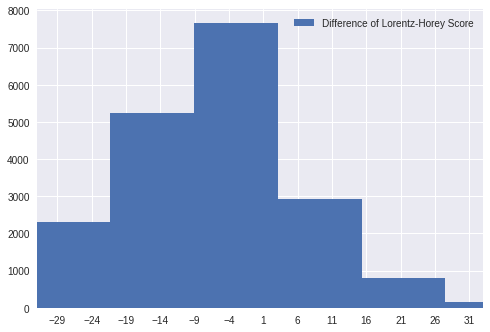

In [97]:
print(df.columns)
col = "lorentz_horey_difference"
val = 10
ax = plt.subplot(111)
print(len(df[df[col] >= val])/ len(df))
print(len(df[df[col] < val]) / len(df))
print(df[col].min())
print(df[col].max())
max_range = max(abs(df[col].min()),abs(df[col].max()))
npatches = []
ticks = np.arange(df[col].min(), df[col].max()+1,5)
plt.xticks(ticks)
ax.set_xlim((0-half,0+half+1))
npatches.append(mpatches.Patch(label='Difference of Lorentz-Horey Score'))
ax.hist(df[col], align="left")
ax.legend(handles=npatches)